In [ ]:
import xarray as xr
import numpy as np
import datetime as dt
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.optimize import curve_fit

### /// Settings for figures /// ###
cmap = mpl.colormaps.get_cmap('plasma').resampled(38)
norm = mpl.colors.Normalize(vmin=0, vmax=15)

### /// LUT for month names, colours, etc. /// ###
mname = dict(zip(range(1, 13), ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))
colours = {'ERA5':'C0', 'MERRA2':'C2', 'JRA55':'C1'}
d_f_dict = {'ERA5':'BrE5', 'MERRA2':'BrM2', 'JRA55':'BrJ55'}

### /// Function to remove linear trend /// ###
def remove_lin(df):

    try:
        x = df.index.get_level_values(1).values
    except IndexError:
        x = df.index.values
    
    try:
        popt, pcov = curve_fit(lambda x,a,b: a*x+b, x, df['Area'])
        return df['Area'].droplevel('threshold') - (popt[0]*x + popt[1])
    except:
        popt, pcov = curve_fit(lambda x,a,b: a*x+b, x, df)
        return df - (popt[0]*x + popt[1])

# Create weights

In [ ]:
mname = dict(zip(range(1, 13), ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))
inv_mname = dict(zip(['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], range(1, 13)))

weekly_data = xr.open_dataset(os.environ['HOME'] + '/L0_JAXA/JAXA.JASMES.sce.valid_dates.nc')
condition_1 = (weekly_data.time.dt.month >= 8)  & (weekly_data.time.dt.year == 1980)
condition_2 = (weekly_data.time.dt.month < 8)  & (weekly_data.time.dt.year == 2020)
condition_3 = (weekly_data.time.dt.year >= 1981) & (weekly_data.time.dt.year <= 2020)

weekly_data = weekly_data.where(condition_1 | condition_2 | condition_3, drop=True)

weight_ds = xr.Dataset()
weight_ds['time'] = weekly_data.time

# Loop over each month and assign a weight to the validity date
# Weight should be equal to the number of days that the week
# Ending on the validity dates contributes to the month in question.
for month in range(1, 13):
    date_subset = weekly_data.time.sel(time = weekly_data.time.dt.month.isin([month, month+1]))

    weights = np.zeros(len(date_subset.values))
    for n,i in enumerate(date_subset.indexes['time']):
        #print(i)
        if (i.month == month) & ((i-dt.timedelta(days=6)).month == month):
            weights[n] = 7 #full week falls in month
        elif (i.month != month) & ((i-dt.timedelta(days=6)).month == month):
            weights[n] = 7-i.day #partial week end of month
        elif (i.month == month) & ((i-dt.timedelta(days=6)).month == month-1) & (month != 1):
            weights[n] = i.day #partial week beginning of month
        elif (i.month == 1) & ((i-dt.timedelta(days=6)).month == 12):
            weights[n] = i.day #partial week beginning of month
        else: 
            weights[n] = 0 #full week not in month
            
    weight_ds[mname[month]] = xr.DataArray(data = weights, coords={'time':date_subset}, dims='time')
    
weight_ds.to_netcdf(os.environ['HOME'] + '/L0_Reference/JAXA_like.weekly_weights.nc')

# Monthly averaging using validity dates from JAXA

In [ ]:
import xarray as xr

def subsample_weight_and_timeav_like_JAXA(indata, month, ylim = [1980, 2020],
                                          weights_loc= os.environ['HOME'] + '/L0_Reference/'):
    '''Apply weighting to weekly input data to average only over the NOAA dates to yield monthly data.

    Parameters
    ----------
    indata : xr.DataArray or xr.Dataset
        input data
    month : int or str
        month of interest
    ylim : list
        year limits to apply weighting from August ymin to July ymax. Default is [1980, 2020].
    '''
    mname = dict(zip(range(1, 13), ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))
    inv_mname = dict(zip(['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], range(1, 13)))

    ### Load weekly weighting data
    weight_ds = xr.open_dataset(weights_loc + 'JAXA_like.weekly_weights.nc')
    
    ### Decode month and select it from weight_ds
    if type(month) == str:
        m_weights = weight_ds[month].dropna(dim='time')
        month_convert_num = inv_mname[month]
    elif type(month) == int:
        m_weights = weight_ds[mname[month]].dropna(dim='time')
        month_convert_num = month
    else:
        raise ValueError('month must be int or str')

    ### Compute weights for month so they sum to 1
    m_weights['start_year'] = (('time'), [i.dt.year-1 if i.dt.month < 8 else i.dt.year for i in m_weights.time])

    m_weights = m_weights.groupby('start_year') / m_weights.groupby('start_year').sum() 

    lower_lim = (m_weights.time.dt.year>ylim[0])|((m_weights.time.dt.month>=8)&(m_weights.time.dt.year==ylim[0]))
    upper_lim = (m_weights.time.dt.year<ylim[1])|((m_weights.time.dt.month<8)&(m_weights.time.dt.year==ylim[1]))

    m_weights = m_weights.where(upper_lim & lower_lim, drop=True).drop_vars('start_year')
    
    m_weights['time'] = m_weights.time.indexes['time']
    
    subset_indata = indata.sel(time=indata.time.dt.date.isin(m_weights.time.dt.date), drop=True)

    weighted_data = (subset_indata * m_weights).resample(time='YS-AUG').sum(dim='time')

    weighted_data = weighted_data.assign_coords(time=weighted_data.time.dt.year).rename({'time':'year'})

    if month < 8:
        weighted_data = weighted_data.assign_coords(year=weighted_data.year+1)

    weight_ds.close()

    return weighted_data

    

# Load JAXA data and fill some clouds

In [ ]:
ref = xr.open_dataset(os.environ['HOME'] + '/L0_Reference/NSIDC_EASE2_N25km_v04.nc')
mask = xr.where((ref.latitude>=40) & (ref.lsmask.isin([1,2])), 1., 0.)

valid_dates_update = xr.open_dataset(os.environ['HOME'] + '/L0_JAXA/JAXA.JASMES.sce.final.nc')

# Monthly trends

In [6]:
JAXA_trends = []

area = ((valid_dates_update * mask).isin([2, 3])).sum(('x','y')) * 25 * 25 / 1e6 # million km2

from scipy.stats import t
from scipy.stats import kendalltau, linregress

tinv = lambda p, df: abs(t.ppf(p/2, df))

for month in [9, 10, 11, 12, 1, 2, 3]:

    ### /// Weight and monthly average, then select NOAA portion /// ###
    JAXA = subsample_weight_and_timeav_like_JAXA(area.to_dataset(name='Area'), month, ylim=[1980, 2020]).dropna(dim='year') # million km2

    ### /// Display result /// ###
    result = linregress(JAXA.year, JAXA['Area'])
    ts = tinv(0.05, len(JAXA.year)-2)  

    ### /// Display result /// ###

    JAXA_trends.append(10*result.slope)
    print('month:', month, f"| slope (95%): {10*result.slope:.2f} +/- {10*ts*result.stderr:.2f}", np.round(result.pvalue,3))
    
    JAXA_trends.append(10*result.slope)

month: 9 | slope (95%): -0.07 +/- 0.27 0.593
month: 10 | slope (95%): -0.55 +/- 0.49 0.03
month: 11 | slope (95%): -1.26 +/- 0.66 0.0
month: 12 | slope (95%): -0.71 +/- 0.44 0.003
month: 1 | slope (95%): -0.26 +/- 0.40 0.194
month: 2 | slope (95%): -0.09 +/- 0.45 0.691
month: 3 | slope (95%): -0.06 +/- 0.45 0.783


# Figure S2

In [7]:
indata = ((valid_dates_update * mask).isin([2, 3])).sum(('x','y')) * 25 * 25 / 1e6 # million km2
Oct_JAXA = subsample_weight_and_timeav_like_JAXA(indata, 10)

In [ ]:
ERA5 = xr.open_dataset(os.environ['HOME'] + '/L2_daily_thresholding/ECMWF.ERA5.reanalysis.all.daily_SCE.40N_90N.nc')
Oct_E5 = ERA5.apply(lambda x: subsample_weight_and_timeav_like_JAXA(x, 10))

In [ ]:
M2 = xr.open_dataset(os.environ['HOME'] + '/L2_daily_thresholding/NASA.MERRA2.reanalysis.all.daily_SCE.40N_90N.nc')
Oct_M2 = M2.apply(lambda x: subsample_weight_and_timeav_like_JAXA(x, 10))

In [ ]:
J55 = xr.open_dataset(os.environ['HOME'] + '/L2_daily_thresholding/JMA.JRA55.reanalysis.all.daily_SCE.40N_90N.nc')
Oct_J55 = J55.apply(lambda x: subsample_weight_and_timeav_like_JAXA(x, 10))

In [11]:
def calc_bestthresh(e5_ds, JAXA_ds):
    
    diff = abs(e5_ds - JAXA_ds).to_array('thresholds')
    years = diff.idxmin('thresholds').dropna('year').year

    
    optimal = xr.concat([e5_ds.to_array('thresholds').sel(year=year, thresholds=diff.idxmin('thresholds').sel(year=year)).drop_vars('thresholds').to_dataset(name='SCE') for year in years],
                       dim='year')
    
    diff.coords['thresholds'] =  [float(i[:-2])/10 for i in diff.thresholds.values]
    diff = diff.idxmin('thresholds').dropna('year').to_dataset(name='NH')

    return diff, optimal

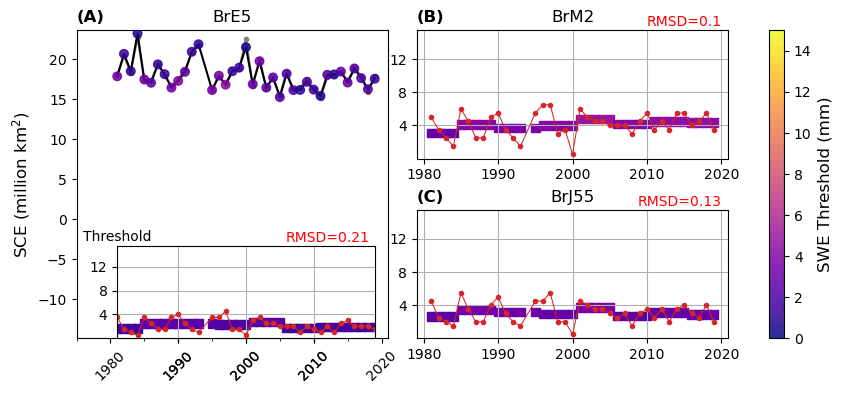

In [ ]:
### /// Set up axes
fig = plt.figure(figsize=(16, 4))
gs = mpl.gridspec.GridSpec(2, 9, height_ratios=[1, 1], wspace=0.35, hspace=0.4)

ax0 = fig.add_subplot(gs[:, 0:3])
ax1 = fig.add_subplot(gs[0, 3:6])
ax2 = fig.add_subplot(gs[1, 3:6])
ax0.set_title('(A)', loc='left', fontweight='bold')
ax1.set_title('(B)', loc='left', fontweight='bold')
ax2.set_title('(C)', loc='left', fontweight='bold')

for region,ax in zip(['NH'], [ax0]):

    diff, optimal = calc_bestthresh(Oct_E5, Oct_JAXA)
    
    Oct_JAXA.plot(ax=ax, label='JAXA JASMES', color='grey', marker='.')
    optimal.SCE.plot(ax=ax, label='BrE5', color='k')

    vals = ax.scatter(optimal.year, optimal.SCE, 
                      c=diff[region], s=38, zorder=3, 
                      cmap=cmap, norm=norm, alpha=0.85)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    # ax.set_xticks(range(1980, 2020+1, 10))
    ax.set_xticks(range(1975, 2020, 5), minor=True)
    ax.tick_params(axis='x', which='both', rotation=45)

### /// Inset plot
### /// Calculate 5-year means and plot as overlay
ylims = ax0.get_ylim()
new_ymin = np.array([ylims[0],(diff['NH'].min().values-0.4*ylims[1])/(1-0.4)]).min()
ax0.set_ylim(ymin=new_ymin)

ax_begin = ax0.transLimits.transform((diff.year[0], 0))[0]
ax_end = ax0.transLimits.transform((diff.year[-1], 0))[0]

inset_ax = ax0.inset_axes([ax_begin, 0, ax_end-ax_begin, 0.3], transform=ax0.transAxes, facecolor='white', alpha=0)
inset_ax.set_xlim(xmin=diff.year[0], xmax=diff.year[-1])
inset_ax.tick_params(axis='x', which='both', rotation=45)

for ax in [inset_ax, ax1, ax2]:
    ax.set_ylim(ymin=0, ymax=15.5)
    ax.grid(which='both')
    ax.set_yticks([4,8,12])



### /// Repeat for other datasets
for ax_instance,final_data in zip([inset_ax, ax1, ax2], [calc_bestthresh(Oct_E5, Oct_JAXA),
                                                calc_bestthresh(Oct_M2, Oct_JAXA),
                                                calc_bestthresh(Oct_J55, Oct_JAXA)]):

    diff, optimal = final_data
    
    NH_rmsd = np.round((abs(optimal.SCE-Oct_JAXA).mean().values), 2)
    ax_instance.text(0.98, 1.01, f'RMSD={NH_rmsd}', transform=ax_instance.transAxes, ha='right', va='bottom', color='red')
    
    diff['NH'].plot(x='year', ax=ax_instance, color='tab:red', linewidth=0.75, marker='.')
    
    elongated = np.nanmean(np.pad(diff['NH'], (1, 1), mode='constant', constant_values=np.nan).reshape(-1, 5), axis=1)
    elongated = np.repeat(elongated, 5)

    # print('1980-1984 avg. best-fit threshold:', elongated[0])
    # print('2015-2019 avg. best-fit threshold:', elongated[-1])
    ax_instance.scatter(diff['NH'].year, elongated[1:-1], c=elongated[1:-1], 
                marker='s', cmap=cmap, norm=norm)

    ax_instance.set_ylabel('')
    ax_instance.set_xlabel('')
    ax_instance.set_title('')

inset_ax.text(0, 1.1, 'Threshold', transform=inset_ax.transAxes, ha='center', va='center', fontsize='medium')

ax0.set_ylabel('SCE (million km$^2$)',fontsize='large')
cbar = plt.colorbar(vals, ax=[ax0,ax1,ax2])
cbar.set_label('SWE Threshold (mm)', fontsize='large')

ax0.set_title('BrE5', loc='center', fontsize='large')
ax1.set_title('BrM2')
ax2.set_title('BrJ55')

plt.savefig(f'FigS2.png', bbox_inches='tight', dpi=300)



# Fig 2

<>:26: SyntaxWarning: invalid escape sequence '\,'
<>:26: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_785561/225594734.py:26: SyntaxWarning: invalid escape sequence '\,'
  label=d_f_dict[model] + '$_{\,JAXA}$',


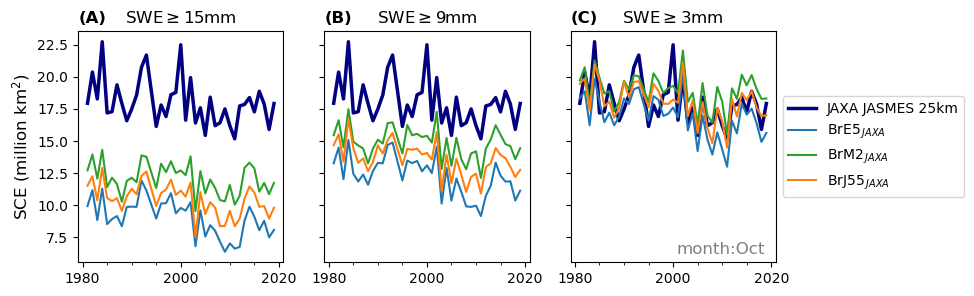

In [ ]:
### /// Setup /// ###
letters = iter(['(A)', '(B)', '(C)'])

month=10
mstr = str(month).zfill(2)
lmm=[40,90]
thresholds_to_plot = [15, 9, 3] #mm

fig, axs = plt.subplots(figsize=(9,3), ncols=3, sharey=True)

### /// Load and plot data /// ###
for data,model in zip([Oct_E5, Oct_M2, Oct_J55], ['ERA5', 'MERRA2', 'JRA55']):
        
        for nt, tval in enumerate(thresholds_to_plot):

            if model == 'ERA5':
                ### Convert units to million km2, using the fact that grid is 25km EASE grid
                Oct_JAXA.dropna('year').plot(ax=axs[nt],
                                                color='navy', 
                                                linewidth=2.5,
                                                ls='-',
                                                label='JAXA JASMES 25km')
            
            ### Plot BTIM, convert units
            data[str(int(tval*10)).zfill(3)+'mm'].dropna('year').plot(ax=axs[nt], 
                                                   label=d_f_dict[model] + '$_{\,JAXA}$', 
                                                   color=colours[model])

### /// Decorate axes /// ###
for nt,tval in enumerate(thresholds_to_plot):
    axs[nt].set_ylabel('')
    axs[nt].set_xlabel('')
    axs[nt].set_xticks(range(1980, 2021, 5), minor=True)
    axs[nt].set_title(next(letters), loc='left', fontweight='bold')
    axs[nt].set_title(r'SWE$\geq$'+str(tval)+'mm')
    
axs[0].set_ylabel('SCE (million km$^2$)', fontsize='large')
plt.text(0.95, 0.025, 'month:'+str(mname[month]), fontsize='large', ha='right', va='bottom', color='grey', transform=axs[-1].transAxes)
axs[-1].legend(bbox_to_anchor=(1, 0.5), loc='center left')

plt.savefig(f'Fig2.png', bbox_inches='tight', dpi=300)

plt.show()
